# Chapter 10: Logistic Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [37]:
!pip install mord 

In [30]:
!pip install dmba

In [31]:
# 

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score


In [32]:
%matplotlib inline

## Table 10.2
Load the `UniversalBank.csv` dataset. The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat Education as categorical

In [33]:
#https://raw.githubusercontent.com/gchoi/Dataset/master/UniversalBank.csv

bank_df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/UniversalBank.csv')
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories, inplace=True)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

y = bank_df['PersonalLoan']
X = bank_df.drop(columns=['PersonalLoan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.12625911059292
            Age  ...  Education_Advanced/Professional
coeff -0.050879  ...                         4.355284

[1 rows x 12 columns]

AIC -709.1524769205962


In [34]:
predictors = ['Income']
outcome = 'PersonalLoan'

y = bank_df[outcome]
X = bank_df[predictors]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -6.048919279034504
               Income
coefficient  0.036343

AIC 843.5163143186965


## Table 10.3
Predict to get the probabilities

In [35]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.952399  0.047601          0
932        0  0.878526  0.121474          0
2721       1  0.440692  0.559308          1
702        1  0.889689  0.110311          0


## Table 10.4

In [36]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9080)

       Prediction
Actual    0    1
     0 2632   81
     1  195   92
Confusion Matrix (Accuracy 0.9110)

       Prediction
Actual    0    1
     0 1763   44
     1  134   59


## Figure 10.3

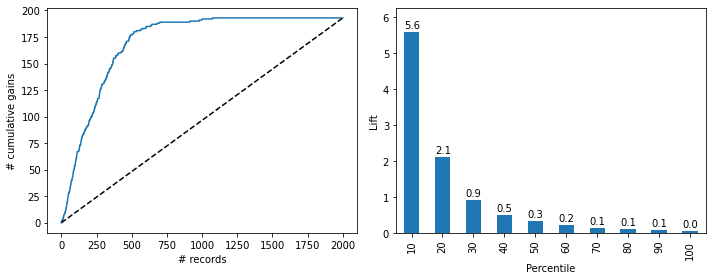

In [38]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

## Figure 10.4

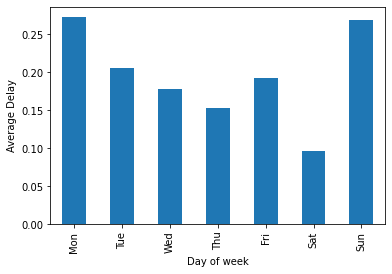

In [39]:
# https://raw.githubusercontent.com/niharikabalachandra/Logistic-Regression/master/FlightDelays.csv
delays_df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/FlightDelays.csv')
# Create an indicator variable

delays_df['isDelayed'] = [1 if status == 'delayed' else 0 for status in delays_df['delay']]

# group information by day of week and determine the average delay
averageDelay = delays_df.groupby(['dayweek'])['isDelayed'].mean()

# create a bar chart
ax = averageDelay.plot.bar(color='C0')
ax.set_xlabel('Day of week')
ax.set_ylabel('Average Delay')
_ = ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

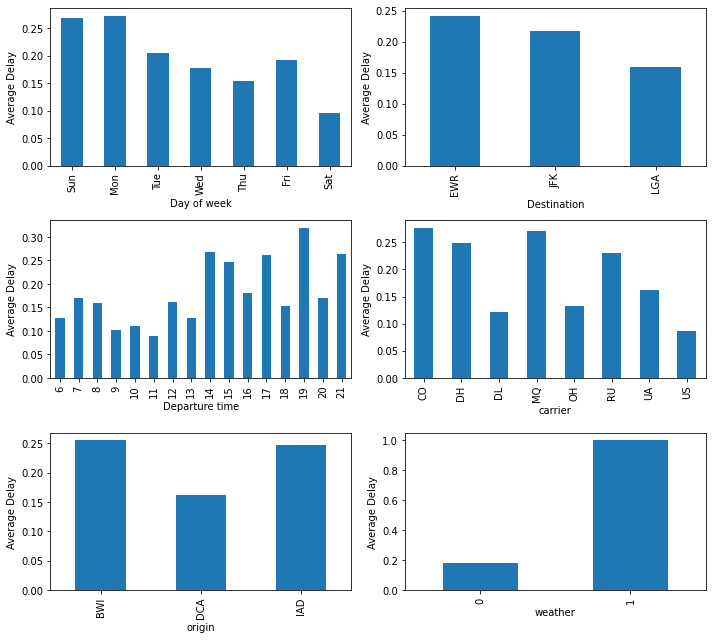

In [40]:
delays_df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['delay']]

def createGraph(group, xlabel, axis):
    groupAverage = delays_df.groupby([group])['isDelayed'].mean()
    if group == 'dayweek': # rotate so that display starts on Sunday
        groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index,1))
        groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

def graphDepartureTime(xlabel, axis):
    temp_df = pd.DataFrame({'schedtime': delays_df['schedtime'] // 100, 
                            'isDelayed': delays_df['isDelayed']})
    groupAverage = temp_df.groupby(['schedtime'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_xlabel(xlabel); ax.set_ylabel('Average Delay')
    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))

createGraph('dayweek', 'Day of week', axis=axes[0][0])
createGraph('dest', 'Destination', axis=axes[0][1])
graphDepartureTime('Departure time', axis=axes[1][0])
createGraph('carrier', 'carrier', axis=axes[1][1])
createGraph('origin', 'origin', axis=axes[2][0])
createGraph('weather', 'weather', axis=axes[2][1])
plt.tight_layout()

plt.show()

## Figure 10.5

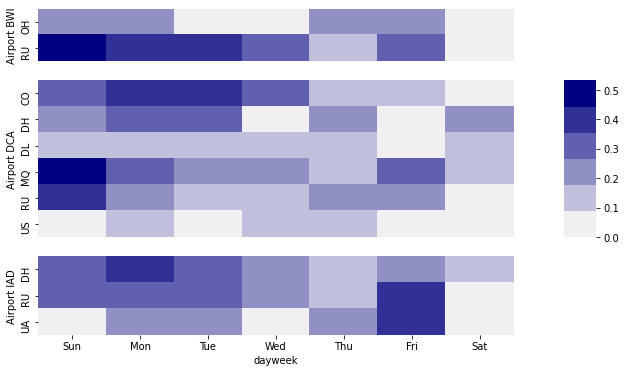

In [41]:
agg = delays_df.groupby(['origin', 'dayweek', 'carrier']).isDelayed.mean()
agg = agg.reset_index()

# Define the layout of the graph
height_ratios = []
for i, origin in enumerate(sorted(delays_df.origin.unique())):
    height_ratios.append(len(agg[agg.origin == origin].carrier.unique()))
gridspec_kw = {'height_ratios': height_ratios, 'width_ratios': [15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), 
                         gridspec_kw = gridspec_kw)
axes[0, 1].axis('off')
axes[2, 1].axis('off')

maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delays_df.origin.unique())):
    data = pd.pivot_table(agg[agg.origin == origin], values='isDelayed', aggfunc=np.sum, 
                          index=['carrier'], columns=['dayweek'])
    data = data[[7, 1, 2, 3, 4, 5, 6]]  # Shift last columns to first
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0, vmax=maxIsDelay, 
                     cbar_ax=axes[1][1], cmap=sns.light_palette("navy"))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    if i != 2: 
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Airport ' + origin)
    

plt.show()

## Table 10.7

In [42]:
delays_df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['delay']]

# convert to categorical
delays_df.dayweek = delays_df.dayweek.astype('category')

# create hourly bins departure time 
delays_df.schedtime = [round(t / 100) for t in delays_df.schedtime]
delays_df.schedtime = delays_df.schedtime.astype('category')

predictors = ['dayweek', 'schedtime', 'origin', 'dest', 'carrier', 'weather']
outcome = 'isDelayed'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

pd.set_option('display.width', 95)
pd.set_option('precision',3)
pd.set_option('max_columns', 33)
print('intercept ', logit_full.intercept_[0])

print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_full.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('precision')
pd.reset_option('max_columns')

intercept  -1.2191099739696425
       weather  dayweek_2  dayweek_3  dayweek_4  dayweek_5  dayweek_6  dayweek_7  \
coeff    9.325     -0.598     -0.705     -0.799     -0.296     -1.129     -0.135   

       schedtime_7  schedtime_8  schedtime_9  schedtime_10  schedtime_11  schedtime_12  \
coeff        0.631        0.382       -0.365         0.337         0.078         0.399   

       schedtime_13  schedtime_14  schedtime_15  schedtime_16  schedtime_17  schedtime_18  \
coeff         0.175         0.202         1.265         0.628         1.093         0.285   

       schedtime_19  schedtime_20  schedtime_21  origin_DCA  origin_IAD  dest_JFK  dest_LGA  \
coeff         1.655         1.023         1.077       -0.01      -0.134    -0.524    -0.546   

       carrier_DH  carrier_DL  carrier_MQ  carrier_OH  carrier_RU  carrier_UA  carrier_US  
coeff       0.352      -0.685       0.743      -0.711      -0.194       0.315      -0.971  

AIC 1004.5346225948085


## Figure 10.6

Confusion Matrix (Accuracy 0.8309)

        Prediction
 Actual  ontime delayed
 ontime     705       9
delayed     140      27


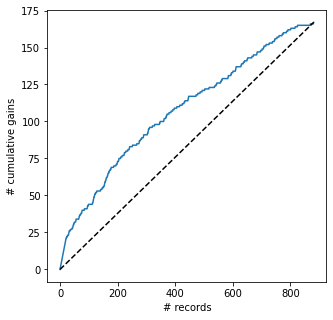

In [43]:
logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(full_result.actual, full_result.predicted, class_names=classes)

gainsChart(full_result.actual, figsize=[5, 5])

plt.show()

## Table 10.9

In [44]:
delays_df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/FlightDelays.csv')
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['delay']]
delays_df['schedtime'] = [round(t / 100) for t in delays_df['schedtime']]
delays_red_df = pd.DataFrame({
    'Sun_Mon' : [1 if d in (1, 7) else 0 for d in delays_df.dayweek],
    'weather' : delays_df.weather,
    'carrier_CO_MQ_DH_RU' : [1 if d in ("CO", "MQ", "DH", "RU") else 0 
                             for d in delays_df.carrier],
    'MORNING' : [1 if d in (6, 7, 8, 9) else 0 for d in delays_df.schedtime],
    'NOON' : [1 if d in (10, 11, 12, 13) else 0 for d in delays_df.schedtime],
    'AFTER2P' : [1 if d in (14, 15, 16, 17, 18) else 0 for d in delays_df.schedtime],
    'EVENING' : [1 if d in (19, 20) else 0 for d in delays_df.schedtime],
    'isDelayed' : [1 if status == 'delayed' else 0 for status in delays_df['delay']],
})

X = delays_red_df.drop(columns=['isDelayed'])
y = delays_red_df['isDelayed']
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

logit_red = LogisticRegressionCV(penalty="l1", solver='liblinear', cv=5)
logit_red.fit(train_X, train_y)

pd.set_option('display.width', 100)
print('regularization', logit_red.C_)
print('intercept ', logit_red.intercept_[0])
print(pd.DataFrame({'coeff': logit_red.coef_[0]}, index=X.columns).transpose())
pd.reset_option('display.width')
print('AIC', AIC_score(valid_y, logit_red.predict(valid_X), df=len(train_X.columns) + 1))


# confusion matrix
classificationSummary(valid_y, logit_red.predict(valid_X), class_names=classes)

regularization [2.7825594]
intercept  -2.2874342902398097
        Sun_Mon   weather  carrier_CO_MQ_DH_RU  ...      NOON   AFTER2P   EVENING
coeff  0.577989  4.977939             1.298833  ... -0.665791 -0.055095  0.560937

[1 rows x 7 columns]
AIC 934.6153607819033
Confusion Matrix (Accuracy 0.8343)

        Prediction
 Actual  ontime delayed
 ontime     711       3
delayed     143      24


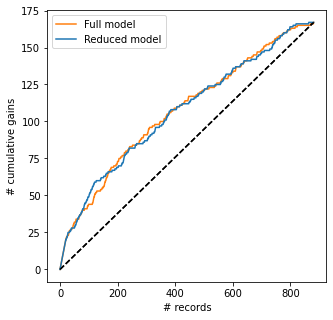

In [45]:
logit_reg_proba = logit_red.predict_proba(valid_X)
red_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_proba],
                            'p(1)': [p[1] for p in logit_reg_proba],
                            'predicted': logit_red.predict(valid_X),
                          })
red_result = red_result.sort_values(by=['p(1)'], ascending=False)

ax = gainsChart(full_result.actual, label='Full model', color='C1', figsize=[5, 5])
ax = gainsChart(red_result.actual, label='Reduced model', color='C0', ax=ax)
ax.legend()

plt.show()

## Table 10.9

In [46]:
# same initial preprocessing and creating dummies

# add constant column
bank_df = sm.add_constant(bank_df, prepend=True)

y = bank_df['PersonalLoan']
X = bank_df.drop(columns=['PersonalLoan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# use GLM (general linear model) with the binomial family to fit a logistic regression
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           PersonalLoan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Tue, 18 May 2021   Deviance:                       680.30
Time:                        18:18:04   Pearson chi2:                 8.10e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [47]:
data = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/AccidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']

y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
classes = sorted(y.unique())

print('Nominal logistic regression')
logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)
print('  intercept', logit.intercept_)
print('  coefficients', logit.coef_)
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
})
print(results.head())
print()


print('Ordinal logistic regression')
logit = LogisticIT(alpha=0)
logit.fit(X, y)
print('  theta', logit.theta_)
print('  coefficients', logit.coef_)
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
})
print(results.head())



Nominal logistic regression
  intercept [-0.09100315  0.9036454  -0.81264225]
  coefficients [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]

   actual  predicted      P(0)      P(1)      P(2)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124

Ordinal logistic regression
  theta [-1.06916285  2.77444326]
  coefficients [-0.40112008 -0.25174207]

   actual  predicted      P(0)      P(1)      P(2)
0       1          1  0.496205  0.482514  0.021281
1       0          0  0.558866  0.424510  0.016624
2       0          0  0.558866  0.424510  0.016624
3       0          1  0.496205  0.482514  0.021281
4       0          1  0.397402  0.571145  0.031453


## Nominal logistic regression

In [48]:
# https://raw.githubusercontent.com/kwartler/Harvard_DataMining_Business_Student/master/BookDataSets/AccidentsFull.csv
data = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/AccidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
print('predictors', predictors)
print()
y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
classes = sorted(y.unique())

logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)

print('intercept', logit.intercept_)
print('coef', logit.coef_)
print('classes', logit.classes_)

probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y,
    'predicted': logit.predict(X),
    'P(a)': [p[0] for p in probs],
    'P(b)': [p[1] for p in probs],
    'P(c)': [p[2] for p in probs],
})
print(results.head())
# classificationSummary(y, results.predicted, class_names=classes)

predictors ['ALCHL_I', 'WEATHER_R']

intercept [-0.09100315  0.9036454  -0.81264225]
coef [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]
classes [0 1 2]
   actual  predicted      P(a)      P(b)      P(c)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124


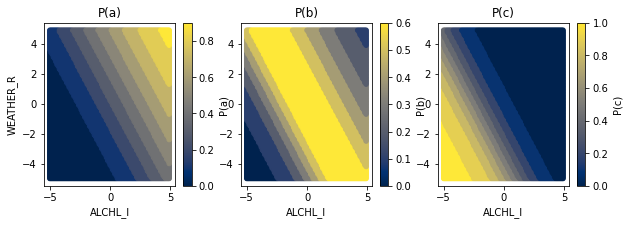

In [49]:
def plotProbabilities(model):
    n = 100
    Xtest = pd.DataFrame({
        'ALCHL_I': [(i % n) * 0.1 + (j // n) * 0.1 - 5 for i in range(n) for j in range(n)],
        'WEATHER_R': [(i // n) * 0.1 + (j % n) * 0.1 - 5 for i in range(n) for j in range(n)],
    })
    probs = logit.predict_proba(Xtest[predictors])

    results = pd.DataFrame({
        'predicted': logit.predict(Xtest[predictors]),
        'P(a)': [round(10 * p[0]) / 10 for p in probs],
        'P(b)': [round(10 * p[1]) / 10 for p in probs],
        'P(c)': [round(10 * p[2]) / 10 for p in probs],
    })
    mapped = pd.concat([results, Xtest], axis=1, sort=False)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    for i, c in enumerate(['P(a)', 'P(b)', 'P(c)']):
        ax = mapped.plot.scatter(x='ALCHL_I', y='WEATHER_R', c=c, title=c, colormap='cividis', ax=axes[i])
        if i > 0: ax.set_ylabel('')
plotProbabilities(logit)

## Ordinal logistic regression

In [50]:
import random
from mord import LogisticIT

data = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/AccidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
y = data[outcome]
X = data[predictors]
X['ALCHL_I']
train_X, train_y = X, y
classes = sorted(y.unique())

logit = LogisticIT(alpha=0)
logit.fit(X, y)

print('theta', logit.theta_)
print('coef', logit.coef_)
print('classes', logit.classes_)
print()


probs = logit.predict_proba(X)

results = pd.DataFrame({
    'actual': [yi + random.gauss(0, 0.001) for yi in y],
    'predicted': logit.predict(X),
    'P(a)': [p[0] + random.gauss(0, 0.001) for p in probs],
    'P(b)': [p[1] + random.gauss(0, 0.001) for p in probs],
    'P(c)': [p[2] + random.gauss(0, 0.001) for p in probs],
})
print(results.head())

# classificationSummary(y, results.predicted, class_names=classes)

theta [-1.06916285  2.77444326]
coef [-0.40112008 -0.25174207]
classes [0 1 2]

     actual  predicted      P(a)      P(b)      P(c)
0  0.999621          1  0.496614  0.483368  0.021792
1 -0.001189          0  0.560055  0.423915  0.015629
2  0.000552          0  0.559280  0.424759  0.015966
3 -0.001227          1  0.495185  0.481399  0.022486
4  0.000538          1  0.397715  0.571735  0.030666


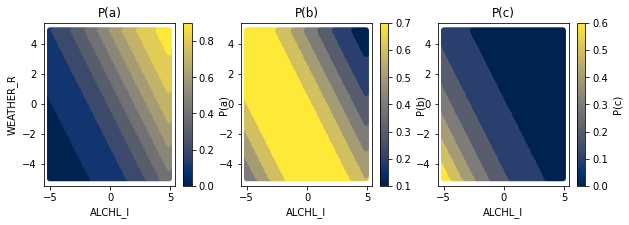

In [51]:
plotProbabilities(logit)